In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.nn as nn

In [3]:
import os
os.environ['METALHOME'] = '/Users/vincentchen/code/metal'

In [4]:
from metal.mmtl.data import MmtlDataLoader, MmtlDataset
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.payload import Payload
from metal.mmtl.task import ClassificationTask
from metal.mmtl.trainer import MultitaskTrainer
from metal.utils import split_data

In [5]:
import matplotlib.pyplot as plt


## Generate Data

In [6]:
N = 200
X = np.random.random((N, 2)) * 2 - 1
Y = (X[:, 0] > X[:, 1] + 0.25).astype(int) + 1

In [7]:
# categorical labels: 
Y1_mask = Y == 1
Y2_mask = Y == 2

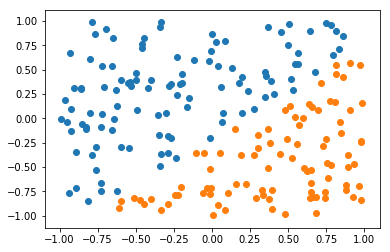

In [8]:
plt.scatter(X[Y1_mask, 0], X[Y1_mask, 1])
plt.scatter(X[Y2_mask, 0], X[Y2_mask, 1])
plt.show()

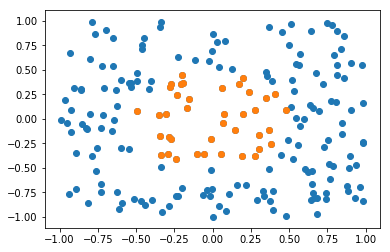

In [9]:
def get_circle_idx(X, center, radius):
    h, k = center
    idx = np.sqrt((X[:, 0] - h) ** 2 + (X[:, 1] - k) ** 2) < radius
    return idx

from functools import partial
circle_fn = partial(get_circle_idx, center=(0.0, 0.0), radius=0.5)
slice_mask = circle_fn(X)

plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X[slice_mask, 0], X[slice_mask, 1])
plt.show()

In [10]:
from metal.mmtl.slicing.slicing import create_slice_task

def create_task(task_name, slice_names=None):    
    input_module = nn.Linear(2, 8)
    head_module = nn.Linear(8, 2)
    middle_module = nn.Linear(8, 8)
    task = ClassificationTask(
        name=task_name, input_module=input_module, middle_module=middle_module, head_module=head_module
    )
    tasks = [task]
    
    for slice_name in slice_names:
        slice_task_name = f"{task_name}:{slice_name}"
        slice_task = create_slice_task(task, slice_task_name)
        tasks.append(slice_task)
    
    return tasks

def create_payloads(task_name, N, batch_size=1, slice_funcs={}):
    payloads = []
    
    labels_to_tasks = {"labelset0": task_name}

    uids = list(range(N))
    X = np.random.random((N, 2)) * 2 - 1
    Y = (X[:, 0] > X[:, 1] + 0.25).astype(int) + 1

    uids = torch.tensor(uids, dtype=torch.long)
    X = torch.tensor(X, dtype=torch.float)
    Y = torch.tensor(Y, dtype=torch.long)

    uid_lists, Xs, Ys = split_data(uids, X, Y, splits=[0.8, 0.1, 0.1], shuffle=True)

    for i, split in enumerate(SPLITS):
        payload_name = f"payload_{split}"
        X_dict = {"data": Xs[i], "uids": uid_lists[i]}
        Y_dict = {"labelset0": Ys[i]}

        if slice_funcs:
            for slice_name, slice_fn in slice_funcs.items():
                slice_mask = slice_fn(Xs[i])
                slice_labels = np.copy(Ys[i])
                slice_labels[np.logical_not(slice_mask)] = 0
                slice_task_name = f"labelset:{slice_name}"
                Y_dict[slice_task_name] = torch.tensor(slice_labels, dtype=torch.long)
                labels_to_tasks[slice_task_name] = f"{task_name}:{slice_name}"

        dataset = MmtlDataset(X_dict, Y_dict)
        data_loader = MmtlDataLoader(dataset, batch_size=batch_size)
        payload = Payload(payload_name, data_loader, labels_to_tasks, split)
        payloads.append(payload)    
        
    return payloads

In [11]:
N = 600
T = 1
SPLITS = ["train", "valid", "test"]
slice_funcs = {"circle": circle_fn}
task_name = "test_task"

In [12]:
tasks = create_task(task_name, slice_names=slice_funcs.keys())
tasks

[ClassificationTask(name=test_task, loss_multiplier=1.0),
 ClassificationTask(name=test_task:circle, loss_multiplier=1.0)]

In [13]:
tasks[0].middle_module == tasks[1].middle_module

True

In [14]:
payloads = create_payloads(task_name, N, batch_size=4, slice_funcs=slice_funcs)
payloads

[Payload(payload_train: labels_to_tasks=[{'labelset0': 'test_task', 'labelset:circle': 'test_task:circle'}], split=train),
 Payload(payload_valid: labels_to_tasks=[{'labelset0': 'test_task', 'labelset:circle': 'test_task:circle'}], split=valid),
 Payload(payload_test: labels_to_tasks=[{'labelset0': 'test_task', 'labelset:circle': 'test_task:circle'}], split=test)]

In [15]:
model = MetalModel(tasks, verbose=False)
model

MetalModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=2, out_features=8, bias=True)
      )
    )
    (test_task:circle): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=2, out_features=8, bias=True)
      )
    )
  )
  (middle_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=8, out_features=8, bias=True)
      )
    )
    (test_task:circle): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=8, out_features=8, bias=True)
      )
    )
  )
  (attention_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
    (test_task:circle): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
  )
  (head_modules): ModuleDict(
   

In [16]:
tasks[0].middle_module, tasks[1].middle_module

(MetalModuleWrapper(
   (module): Linear(in_features=8, out_features=8, bias=True)
 ), MetalModuleWrapper(
   (module): Linear(in_features=8, out_features=8, bias=True)
 ))

In [17]:
tasks[0].input_module is tasks[1].input_module

True

In [18]:
tasks[0].input_module == tasks[1].input_module

True

In [19]:
tasks[0].head_module == tasks[1].head_module

False

In [20]:
tasks[0].head_module is tasks[1].head_module

False

In [21]:
trainer = MultitaskTrainer(verbose=False, lr=0.005)

In [22]:
metrics_dict = trainer.train_model(model, payloads, verbose=False)
metrics_dict

Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x1225b60a0>
Traceback (most recent call last):
  File "/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/tqdm/_tqdm_notebook.py", line 226, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


RuntimeError: size mismatch, m1: [4 x 2], m2: [8 x 2] at /Users/administrator/nightlies/pytorch-1.0.0/wheel_build_dirs/conda_3.6/conda/conda-bld/pytorch_1544137972173/work/aten/src/TH/generic/THTensorMath.cpp:940